In [ ]:
from importnb import Notebook
with Notebook():
    import news_analysis
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sshtunnel import SSHTunnelForwarder
import pymongo
import datetime
import pickle
from glob import glob
import re
from copy import deepcopy
# from multiprocessing import Pool
from tqdm import tqdm_notebook
from collections import Counter
from joblib import delayed, Parallel

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.ensemble import VotingClassifier
from xgboost import XGBRegressor, XGBClassifier
import hyperopt
from hyperopt import hp

import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

In [ ]:
PATH_TO_DATA = 'data/twitter_models/'

#### Metrics

In [ ]:
def accuracy(y_true, y_pred):
    return metrics.accuracy_score(y_true, y_pred)

def precision(y_true, y_pred): # price up is positive if not down
    return metrics.precision_score(y_true, y_pred)

def recall(y_true, y_pred, down=False): # price up is positive if not down
    return metrics.recall_score(y_true, y_pred)

def f1_score(y_true, y_pred, down=False): # price up is positive if not down
    return metrics.f1_score(y_true, y_pred)

def roc_auc(y_true, y_pred, down=False): # price up is positive if not down
    return metrics.roc_auc_score(y_true, y_pred)
    
def summary(y_true, y_pred):
    l = []
    l.append('Acc: ' + str(accuracy(y_true, y_pred)))
    l.append('Precison: ' + str(precision(y_true, y_pred)))
    l.append('Recall: ' + str(recall(y_true, y_pred)))
    l.append('F1: ' + str(f1_score(y_true, y_pred)))
    l.append('ROC AUC: ' + str(roc_auc(y_true, y_pred)))
    l.append('Confusion matrix:')
    print('\n'.join(l))
    conf_matr = metrics.confusion_matrix(y_true, y_pred, labels=[0,1])
    print(pd.DataFrame({str(i): conf_matr[:,i]for i in [0,1]}))

#### Downloading database from server

In [ ]:
def load_collection(db, collection):
    MONGO_HOST = "148.251.21.37"
    MONGO_DB = "cryptopanic_latest"
    MONGO_USER = "andrii"
    MONGO_PASS = "andrii"
    
    server = SSHTunnelForwarder(
        MONGO_HOST,
        ssh_username=MONGO_USER,
        ssh_password=MONGO_PASS,
        remote_bind_address=('127.0.0.1', 27017)
    )
    
    server.start()
    l = []
    try:
        client = pymongo.MongoClient('127.0.0.1', server.local_bind_port)
        c = client[db]
        col = c[collection]
        n_rec = col.count_documents({})
        print('Total records:', n_rec)
        cursor = col.find()
        l = []
        for rec in tqdm_notebook(cursor, total=n_rec):
            l.append(rec)
        
    except Exception as e:
        print(e)

    server.close()  
    df = pd.DataFrame(l)
    return df


def dump_dataframe(df, name):
    pickle.dump(df, open(name+datetime.datetime.now().strftime("%Y%m%dT%H%M")+'.pkl', 'wb'))
    
def load_dataframe_latest(name):
    paths = glob(name+'*.pkl')
    dates = np.array([datetime.datetime.strptime(
                                    re.findall(pattern='([0-9]{8}T[0-9]{4})', string=path)[0], '%Y%m%dT%H%M') 
                             for path in paths])

    last_df = name+dates.max().strftime("%Y%m%dT%H%M")+'.pkl'
    df = pickle.load(open(last_df, 'rb'))
    return df

#### Loading latest DataFrame

In [ ]:
df_users = load_dataframe_latest(PATH_TO_DATA+'df_users')
df_tweets = load_dataframe_latest(PATH_TO_DATA+'df_tweets')

In [ ]:
df_users.head()

In [ ]:
df_tweets.head()

#### Some changes to DataFrames

In [ ]:
def moving_sum(a, window):
    b = np.concatenate([np.zeros(window-1), a])
    A = np.concatenate([b[i:b.shape[0]-window+1+i].reshape(-1,1) for i in range(window)], axis=1)
    ms = A.sum(axis=1)
    return ms

def moving_average(a, window):
    ms = moving_sum(a, window)
    ma = ms / np.concatenate([np.arange(1,window), np.ones(ms.shape[0] - window + 1) * window])
    return ma

In [ ]:
assert Counter(df_users.id).most_common()[0][1] == 1
assert Counter(df_tweets.id).most_common()[0][1] == 1
df_users.set_index('id', inplace=True)
df_tweets.set_index('id', inplace=True)

In [ ]:
def add_user_info(df_tweets, df_users):
    df = df_tweets.copy()
    columns = ['followers', 'friends', 'tweets']
    ar = np.array([df_users.loc[user][columns].values for user in tqdm_notebook(df.id_user_owner.values)])
    for i, column in enumerate(columns):
        df[column] = ar[:,i]
    return df

In [ ]:
df = pickle.load(open(PATH_TO_DATA+'df.tmp','rb'))
ts = df.created_at.values.astype(datetime.datetime) // 1000000000
df['created_at'] = np.array(list(map(datetime.datetime.fromtimestamp, ts)))
df.set_index(ts, inplace=True)
df.sort_index(inplace=True)

In [ ]:
Counter(df.kind.values)

In [ ]:
kind_dict = {'tweet': 0,'retweeted': 1,'retweeted-reply': 2,'quoted': 3,'quoted-reply': 4}
df['kind'] = df['kind'].apply(lambda x: kind_dict[x])

In [ ]:
df = df.loc[:,['created_at', 'kind', 'likes', 'retweets', 'text']]

In [ ]:
window_likes = 100
for column in ['likes', 'retweets']:
    df[column+'_ma'] = moving_average(df[column].values, 100)

In [ ]:
df.head()

#### Downloading prices

In [ ]:
def to_datetime(iterable, pattern='%Y-%m-%dT%H:%M', period_seconds=5*60):
    '''
    patterns:
    '%m/%d/%Y %H:%M' for `date_modified`
    '%Y-%m-%dT%H:%M' for `created_at`
    '''
    dates = np.array([datetime.datetime.strptime(date_str[:16], pattern) for date_str in iterable])
    dates = np.array([datetime.datetime.fromtimestamp((date.timestamp() // period_seconds) * period_seconds) for date in dates])
    return dates

def download_prices(start=1405699200, end=9999999999, period_seconds=300, currency='BTC'):
    '''
    download prices (pair USDT/BTC) from poloniex
    returns dataframe
    '''
    address = 'https://poloniex.com/public?command=returnChartData&currencyPair=USDT_'+currency+'&start='+ \
                str(start)+'&end='+str(end)+'&period='+str(period_seconds)
    df_prices = pd.read_json(address)
    return df_prices

def get_prices_at_date(timestamps, df_prices, price='close', period=5*60):
    '''
    timestamps and prices need to be sorted
    '''
    prices = []
    df = df_prices.copy()
    prices_ts = df.date.values.astype(datetime.datetime) // 1000000000
    
    s_prices = df_prices.loc[:,price]
    s_prices.index = prices_ts
    
    dates = (timestamps // period) * period
    for date in tqdm_notebook(dates):
        
        if date in s_prices.index:
            prices.append(s_prices[date])
        else:
            prices.append(0)
    return np.array(prices)

In [ ]:
df_prices = pickle.load(open('df_prices.pkl', 'rb'))
prices0 = get_prices_at_date(df.index.values, df_prices)
prices1 = get_prices_at_date(df.index.values + 6*60*60, df_prices)

In [ ]:
df['price'] = prices0
df['target'] = prices1
df = df[df.price > 0]

#### Split dataset

In [ ]:
dates = np.array([datetime.datetime.strptime(re.findall(pattern='([0-9]{8}T[0-9]{4})',
                                                        string=path)[0], '%Y%m%dT%H%M') 
                  for path in glob('data/news_models/dbnews*.pkl')])

last_db_news = 'data/news_models/dbnews' + dates.max().strftime("%Y%m%dT%H%M")+ '.pkl'
CENSORED_WORDS, CENSORED_NLEMMAS = news_analysis._get_censored_nlemmas(last_db_news)

In [ ]:
def _preprocess(texts):
    processed_texts = news_analysis._get_texts(texts)
    return processed_texts

def find_indexes(preprocessed_texts, words):
    ixs = []
    for i, texts in enumerate(tqdm_notebook(preprocessed_texts)):
        t = ' '.join(texts)
        for w in words:
            match_list = re.findall(pattern='({})'.format(w),string=t)
            if len(match_list) >= 1:
                ixs.append(i)
                break
    return np.array(ixs)

drop old twitts

In [ ]:
df = df[df.created_at >= '2016-01-01 00:00:00'] 

drop non relavant twitts

In [ ]:
preprocessed_texts = _preprocess(df.text.values)

In [ ]:
flatten = lambda l: [item for sublist in l for item in sublist]
ixs = find_indexes(preprocessed_texts, 
                  np.unique(np.array(list(CENSORED_WORDS) + flatten(CENSORED_NLEMMAS))))

In [ ]:
df.shape, ixs.shape

# Start here

In [ ]:
df = pickle.load(open(PATH_TO_DATA+'df_preprocessed.tmp','rb'))

In [ ]:
class D2Vmodel:
    def __init__(self, vector_size=10, window=2, min_count=1, n_jobs=1,
                 alpha=0.1, min_alpha=0.0001, steps=5,
                 censored=False):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.d2v_model = None
        self.n_jobs = n_jobs
        self.censored = censored
        self.alpha = alpha
        self.min_alpha = min_alpha
        self.steps = steps
    
    def fit_transform(self, titles, verbose=0):
        texts = self._preprocess(titles)
        if verbose > 0:
            documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(tqdm_notebook(texts, desc='tag'))]
        else:
            documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(texts)]
        self.d2v_model = Doc2Vec(documents, 
                                 vector_size=self.vector_size, 
                                 window=self.window, 
                                 min_count=self.min_count, 
                                 workers=self.n_jobs)
        if verbose > 0:
            X = np.array([self.d2v_model.infer_vector(text, self.alpha, self.min_alpha, self.steps) 
                          for text in tqdm_notebook(texts, desc='fit')])
        else: 
            X = np.array([self.d2v_model.infer_vector(text, self.alpha, self.min_alpha, self.steps) 
                          for text in texts])
        return X
    
    def transform(self, titles, verbose=0):
        texts = self._preprocess(titles)
        if verbose > 0:
            X = np.array([self.d2v_model.infer_vector(text, self.alpha, self.min_alpha, self.steps) 
                          for text in tqdm_notebook(texts, desc='fit')])
        else: 
            X = np.array([self.d2v_model.infer_vector(text, self.alpha, self.min_alpha, self.steps) 
                          for text in texts])
        return X
    
    def _preprocess(self, titles):
        texts = _preprocess(titles)
        if self.censored:
            texts = news_analysis._censor(texts, CENSORED_WORDS, CENSORED_NLEMMAS)
        return texts

def split_data(df, train_size, lag):
    train, test = train_test_split(df, train_size=train_size, shuffle=False)
    last_train = train.index.values[-1]
    test = test[test.index.values >= last_train + lag]
    return train, test
    
def d2v_fit_transform_dataframe(df_train, df_test, d2v, verbose=0):
    texts_train, texts_test = df_train.text.values, df_test.text.values
    df_train, df_test = df_train.drop(columns='text'), df_test.drop(columns='text')
    emb_train = d2v.fit_transform(texts_train, verbose=verbose)
    emb_test = d2v.transform(texts_test, verbose=verbose)
    for i in range(emb_train.shape[1]):
        df_train['emb'+str(i)] = emb_train[:,i]
        df_test['emb'+str(i)] = emb_test[:,i]
    return df_train, df_test

#### Preprocess data

In [ ]:
df.head()

In [ ]:
train, test = split_data(df.loc[:,['text', 'price', 'target']], 0.6, 6*60*60)

In [ ]:
def series_to_dataset(df, window):
    dfs = [df.drop(columns='target').iloc[i:df.shape[0]+i-window+1] for i in range(window)]
    for i in range(window):
        dfs[i]['timestamp'] = dfs[i].index.values
        dfs[i].columns = dfs[i].columns + '_' + str(i)
        dfs[i].set_index(np.arange(dfs[i].shape[0]), inplace=True)
    dataset = pd.concat(dfs, axis=1)
    dataset.set_index(df.index.values[window-1:], inplace=True)
    dataset['target'] = df.target.values[window-1:]
    return dataset

def get_target_up(prices0, prices1, threshold=0.002):
    target = prices1 / prices0 - 1
    target_class = [0 if t < threshold else 1 for t in target]
    return np.array(target_class)

def get_target_down(prices0, prices1, threshold=0.002):
    target = prices1 / prices0 - 1
    target_class = [0 if t > - threshold else 1 for t in target]
    return np.array(target_class)

def get_X_y(dataset, target_function, threshold=0.002):
    target = dataset.target.values
    price_columns = []
    for col in dataset.columns:
        if 'price_' in col:
            price_columns.append(col)
    prices0 = dataset.loc[:,price_columns[np.array([int(col[6:]) for col in price_columns]).argmax()]].values
    prices1 = dataset.target.values
    y = target_function(prices0, prices1, threshold)
    X = dataset.drop(columns='target')
    return X, y

def add_bootstrap_samples(x, y):
    count = np.bincount(y)
    n0, n1 = tuple(count)
    label = count.argmin()
    another_label = 1 - label
    
    rare_samples_indexes = np.arange(x.shape[0])[y == label]
    n_new_samples = count[another_label] - count[label]
    indexes = np.random.choice(rare_samples_indexes, size=n_new_samples).astype(int)
    new_samples = x.iloc[indexes]
    new_labels = y[indexes]
    return pd.concat([x, new_samples]), np.concatenate([y, new_labels])

In [ ]:
dataset_train = series_to_dataset(df_train, 10)
dataset_test = series_to_dataset(df_test, 10)

X_up_train, y_up_train = get_X_y(dataset_train, get_target_up, threshold=0.002)
X_up_test, y_up_test = get_X_y(dataset_test, get_target_up, threshold=0.002)

X_down_train, y_down_train = get_X_y(dataset_train, get_target_down, threshold=0.002)
X_down_test, y_down_test = get_X_y(dataset_test, get_target_down, threshold=0.002)

In [ ]:
columns = []
for col in X_up_train.columns:
    if 'emb' in col:
        columns.append(col)
        
X_up_train, X_up_test = X_up_train.loc[:,columns], X_up_test.loc[:,columns]
X_down_train, X_down_test = X_down_train.loc[:,columns], X_down_test.loc[:,columns]

X_up_train, y_up_train = add_bootstrap_samples(X_up_train, y_up_train)
X_down_train, y_down_train = add_bootstrap_samples(X_down_train, y_down_train)

In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True)

In [ ]:
logit_up = LogisticRegressionCV(cv=cv, scoring='precision', n_jobs=-1).fit(X_up_train, y_up_train)
logit_down = LogisticRegressionCV(cv=cv, scoring='precision' , n_jobs=-1).fit(X_down_train, y_down_train)

In [ ]:
logit_up

In [ ]:
pred_up = logit_up.predict(X_up_test)
pred_down = logit_down.predict(X_down_test)

In [ ]:
np.bincount(y_up_test)

In [ ]:
summary(y_up_test, pred_up)

In [ ]:
np.bincount(y_down_test)

In [ ]:
summary(y_down_test, pred_down)

In [ ]:
D2Vmodel()

In [ ]:
for window in [2, 3, 4, 5]:
    for vector_size in [5,10,20,40,70,100]:
        print('window =', window, '; vector_size =', vector_size)
        d2v = D2Vmodel(n_jobs=-1, steps=5, window=window, vector_size=vector_size)
        train, test = split_data(df.loc[:,['text', 'price', 'target']], 0.6, 6*60*60)
        df_train, df_test = d2v_fit_transform_dataframe(train, test, d2v, verbose=1)
        
        dataset_train = series_to_dataset(df_train, 10)
        dataset_test = series_to_dataset(df_test, 10)
        X_up_train, y_up_train = get_X_y(dataset_train, get_target_up, threshold=0)
        X_up_test, y_up_test = get_X_y(dataset_test, get_target_up, threshold=0)
        X_down_train, y_down_train = get_X_y(dataset_train, get_target_down, threshold=0)
        X_down_test, y_down_test = get_X_y(dataset_test, get_target_down, threshold=0)
        
        columns = []
        for col in X_up_train.columns:
            if 'emb' in col:
                columns.append(col)

        X_up_train, X_up_test = X_up_train.loc[:,columns], X_up_test.loc[:,columns]
        X_down_train, X_down_test = X_down_train.loc[:,columns], X_down_test.loc[:,columns]

        X_up_train, y_up_train = add_bootstrap_samples(X_up_train, y_up_train)
        X_down_train, y_down_train = add_bootstrap_samples(X_down_train, y_down_train)
        
        cv = StratifiedKFold(n_splits=3, shuffle=True)

        logit_up = LogisticRegressionCV(cv=cv, scoring='precision', n_jobs=-1).fit(X_up_train, y_up_train)
        logit_down = LogisticRegressionCV(cv=cv, scoring='precision' , n_jobs=-1).fit(X_down_train, y_down_train)

        pred_up = logit_up.predict(X_up_test)
        pred_down = logit_down.predict(X_down_test)

        summary(y_up_test, pred_up)
        summary(y_down_test, pred_down)

In [ ]:
preds_up = []
preds_down = []

for window in [2, 3, 4, 5]:
    for vector_size in [5,10,20,40,70,100]:
        print('window =', window, '; vector_size =', vector_size)
        d2v = D2Vmodel(n_jobs=-1, steps=5, window=window, vector_size=vector_size)
        train, test = split_data(df.loc[:,['text', 'price', 'target']], 0.6, 6*60*60)
        df_train, df_test = d2v_fit_transform_dataframe(train, test, d2v)
        
        dataset_train = series_to_dataset(df_train, 10)
        dataset_test = series_to_dataset(df_test, 10)
        X_up_train, y_up_train = get_X_y(dataset_train, get_target_up, threshold=0.002)
        X_up_test, y_up_test = get_X_y(dataset_test, get_target_up, threshold=0.002)
        X_down_train, y_down_train = get_X_y(dataset_train, get_target_down, threshold=0.002)
        X_down_test, y_down_test = get_X_y(dataset_test, get_target_down, threshold=0.002)
        
        columns = []
        for col in X_up_train.columns:
            if 'emb' in col:
                columns.append(col)

        X_up_train, X_up_test = X_up_train.loc[:,columns], X_up_test.loc[:,columns]
        X_down_train, X_down_test = X_down_train.loc[:,columns], X_down_test.loc[:,columns]

        X_up_train, y_up_train = add_bootstrap_samples(X_up_train, y_up_train)
        X_down_train, y_down_train = add_bootstrap_samples(X_down_train, y_down_train)
        
        cv = StratifiedKFold(n_splits=3, shuffle=True)

        logit_up = LogisticRegressionCV(cv=cv, scoring='precision', n_jobs=-1).fit(X_up_train, y_up_train)
        logit_down = LogisticRegressionCV(cv=cv, scoring='precision' , n_jobs=-1).fit(X_down_train, y_down_train)

        pred_up = logit_up.predict(X_up_test)
        pred_down = logit_down.predict(X_down_test)

        preds_up.append(pred_up)
        preds_down.append(pred_down)
        
        summary(y_up_test, pred_up)
        summary(y_down_test, pred_down)
        print()

# TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def text_vectorizer_fit_transform_dataframe(df_train, df_test, vectorizer, return_embeddings=False):
    texts_train, texts_test = df_train.text.values, df_test.text.values
    df_train, df_test = df_train.drop(columns='text'), df_test.drop(columns='text')
    print('Fit')
    emb_train = vectorizer.fit_transform(texts_train)
    print('Transform')
    emb_test = vectorizer.transform(texts_test)
    print('Done')
    if return_embeddings:
        return emb_train, emb_test
    for i in tqdm_notebook(range(emb_train.shape[1])):
        df_train['emb'+str(i)] = emb_train[:,i]
        df_test['emb'+str(i)] = emb_test[:,i]
    return df_train, df_test

In [ ]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,2))

In [ ]:
train, test = split_data(df.loc[:,['text', 'price', 'target']], 0.6, 6*60*60)

In [ ]:
emb_train, emb_test = text_vectorizer_fit_transform_dataframe(train, test, tfidf, return_embeddings=True)

In [ ]:
from scipy.sparse import hstack

def series_to_dataset_sparse(emb, window):
    dfs = [emb[i:emb.shape[0]+i-window+1] for i in range(window)]
    dataset = hstack(dfs, format='csr')
#     dataset = pd.concat(dfs, axis=1)
#     dataset.set_index(df.index.values[window-1:], inplace=True)
#     dataset['target'] = df.target.values[window-1:]
    return dataset

In [ ]:
X_train = series_to_dataset_sparse(emb_train, 10)
X_test = series_to_dataset_sparse(emb_test, 10)

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=1000)
Xt_train = svd.fit_transform(X_train)
Xt_test = svd.transform(X_test)

In [ ]:
threshold = 0.002

prices0 = train.price.values[9:]
prices1 = train.target.values[9:]
y_up_train = get_target_up(prices0, prices1, threshold)
y_down_train = get_target_down(prices0, prices1, threshold)

prices0 = test.price.values[9:]
prices1 = test.target.values[9:]
y_up_test = get_target_up(prices0, prices1, threshold)
y_down_test = get_target_down(prices0, prices1, threshold)

In [ ]:
%%time
cv = TimeSeriesSplit(n_splits=2)

logit_up = LogisticRegressionCV(cv=cv, scoring='precision', n_jobs=-1, Cs=2).fit(X_train, y_up_train)
logit_down = LogisticRegressionCV(cv=cv, scoring='precision' , n_jobs=-1, Cs=2).fit(X_train, y_down_train)

In [ ]:
pred_up = logit_up.predict(X_test)
pred_down = logit_down.predict(X_test)

np.bincount(y_up_test)

summary(y_up_test, pred_up)

np.bincount(y_down_test)

summary(y_down_test, pred_down)

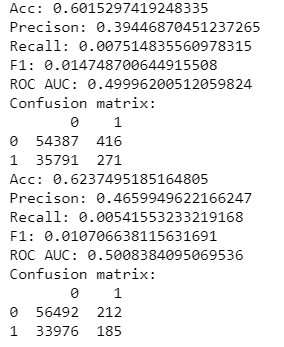

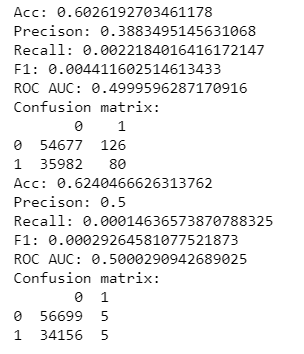